In [39]:
# h/t to this tutorial for helping me get started 
# https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/

In [40]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import numpy as np
from dateutil import parser

## establish api connection ##

In [41]:
consumer_key = [ENTER CONSUMER_KEY]
consumer_secret = [ENTER CONSUMER_SECRET]
access_token = [ENTER ACESS_TOKEN]
access_secret = [ENTER ACESS_SECRET]
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

## pull and store all of my account's twitter activity ##

In [42]:
my_tweets = []

for tweet in tweepy.Cursor(api.user_timeline).items():
    my_tweets.append(tweet._json)

In [43]:
my_tweets_df = pd.DataFrame()

for i in range(len(my_tweets)):
    # basic tweet info #
    my_tweets_df.loc[i,'tweet_id'] = str(my_tweets[i]['id'])
    my_tweets_df.loc[i,'user'] = my_tweets[i]['user']['screen_name']
    my_tweets_df.loc[i,'source'] = my_tweets[i]['source']
    # date #
    my_tweets_df.loc[i,'created_at'] = my_tweets[i]['created_at']
    my_tweets_df.loc[i,'datetime'] = parser.parse(my_tweets[i]['created_at']) # dete parsing
    my_tweets_df.loc[i,'year_month'] = my_tweets_df['datetime'][i].strftime("%Y-%m") # YYYY-MM format
    # tweet content #
    my_tweets_df.loc[i,'text'] = my_tweets[i]['text']
    # user created columns #
    my_tweets_df.loc[i,'is_comment'] = not not my_tweets[i]['in_reply_to_status_id']
    my_tweets_df.loc[i,'is_retweet'] = 'RT @' in my_tweets[i]['text']    

# sort df datetime
my_tweets_df = my_tweets_df.sort_values('datetime')    

#### comments and retweets are mutually exclusive in the dataset ####

In [44]:
my_tweets_df[(my_tweets_df['is_comment'] == True) & (my_tweets_df['is_retweet'] == True)]

,tweet_id,user,source,created_at,datetime,year_month,text,is_comment,is_retweet


#### breakout twitter actvity by type: tweet, retweet, or comment ####

In [45]:
my_tweets_df['tweet_type'] = np.where(my_tweets_df['is_comment'] == True, 'comment',
                                     np.where(my_tweets_df['is_retweet'] == True, 'retweet','tweet'))

my_tweets_df[['tweet_type']].groupby('tweet_type').size()

tweet_type
comment    147
retweet    187
tweet      133
dtype: int64

## inspect dataframe info and data ##

In [46]:
my_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467 entries, 466 to 0
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    467 non-null    object
 1   user        467 non-null    object
 2   source      467 non-null    object
 3   created_at  467 non-null    object
 4   datetime    467 non-null    object
 5   year_month  467 non-null    object
 6   text        467 non-null    object
 7   is_comment  467 non-null    object
 8   is_retweet  467 non-null    object
 9   tweet_type  467 non-null    object
dtypes: object(10)
memory usage: 40.1+ KB


In [47]:
my_tweets_df.head()

,tweet_id,user,source,created_at,datetime,year_month,text,is_comment,is_retweet,tweet_type
466,850133406885216256,n_feifel,"<a href=""http://twitter.com/download/iphone"" r...",Thu Apr 06 23:49:33 +0000 2017,2017-04-06 23:49:33+00:00,2017-04,Thanks @dzoldan for the tickets to @StandUpNY!...,False,False,tweet
465,859205162908483584,n_feifel,"<a href=""http://twitter.com/download/iphone"" r...",Tue May 02 00:37:28 +0000 2017,2017-05-02 00:37:28+00:00,2017-05,"Hey @Cubs, had a fun time cheering on the squa...",False,False,tweet
464,872438488364351488,n_feifel,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Wed Jun 07 13:01:59 +0000 2017,2017-06-07 13:01:59+00:00,2017-06,RT @dkbaw: Come check out our Father's day Pop...,False,True,retweet
463,894026879577059328,n_feifel,"<a href=""http://twitter.com/download/iphone"" r...",Sun Aug 06 02:46:32 +0000 2017,2017-08-06 02:46:32+00:00,2017-08,RT @Inc: How your business can profit from the...,False,True,retweet
462,899958507495202816,n_feifel,"<a href=""http://twitter.com/download/iphone"" r...",Tue Aug 22 11:36:43 +0000 2017,2017-08-22 11:36:43+00:00,2017-08,RT @Inc: Traditional Networking Events Are Dea...,False,True,retweet


#### most of my activity is on mobile ####

In [48]:
my_tweets_df[['source']].groupby('source').size()

source
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     71
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>    384
<a href="https://medium.com" rel="nofollow">Medium</a>                                  3
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                 9
dtype: int64

## visualizing my activity ##

In [49]:
# create list of months between my first and latest activity
start_date = min(my_tweets_df['datetime']).strftime("%Y-%m-01")
end_date = max(my_tweets_df['datetime']).strftime("%Y-%m-01")

months = pd.date_range(start_date,end_date,
              freq='MS').strftime("%Y-%m").to_series().to_frame('year_month')

In [50]:
# aggregate my activity by month
data_to_plot = my_tweets_df[['tweet_id','year_month','tweet_type']].groupby(['year_month','tweet_type']).size().to_frame('count').reset_index()
data_to_plot = months.merge(data_to_plot, how = 'left', left_on = 'year_month', right_on = 'year_month')

data_to_plot['tweet_type'].fillna('tweet', inplace = True)

In [51]:
# pivot data so it is in plotting format
data_to_plot = data_to_plot.pivot_table(index = 'year_month', columns = 'tweet_type', values = 'count', aggfunc = np.sum).fillna(0)
data_to_plot = data_to_plot.sort_values('year_month')
data_to_plot.head(10)

tweet_type,comment,retweet,tweet
year_month,,,
2017-04,0.0,0.0,1.0
2017-05,0.0,0.0,1.0
2017-06,0.0,1.0,0.0
2017-07,0.0,0.0,0.0
2017-08,0.0,3.0,0.0
2017-09,1.0,4.0,3.0
2017-10,1.0,1.0,0.0
2017-11,1.0,1.0,5.0
2017-12,11.0,5.0,8.0


### tweet activity over time ###

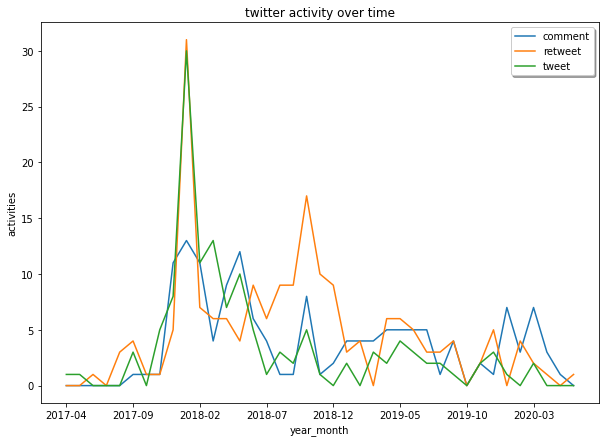

In [52]:
plot1 = data_to_plot.plot.line(figsize = [10,7], title = 'twitter activity over time')
plot1.set_ylabel('activities')
plot1.legend(shadow=True)

### twitter activity over time by activity type ###

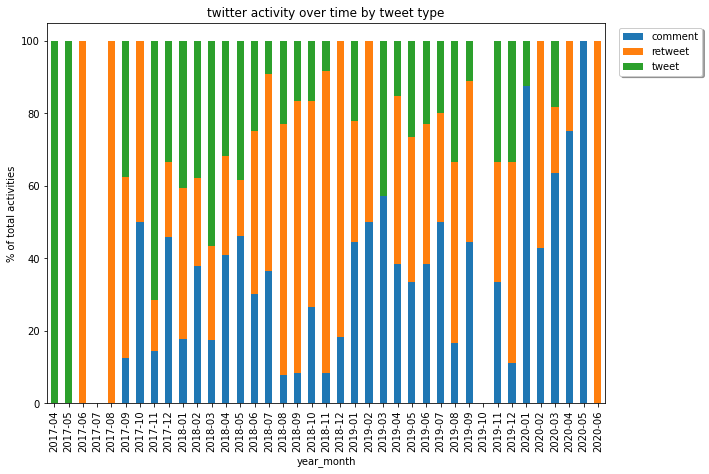

In [53]:
data_to_plot2 = data_to_plot.apply(lambda x: x*100/sum(x), axis=1)
plot2 = data_to_plot2.plot.bar(stacked = True, figsize = [10,7], title = 'twitter activity over time by tweet type')
plot2.set_ylabel('% of total activities')
plot2.legend(loc='upper center', bbox_to_anchor=(1.1, 1), shadow=True)